# Sars Cov2 PubMed MeSH Terms Network Graph Analysis & Visualization

In [1]:
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
file_path =  "/content/drive/MyDrive/04-Work/EDA-Comparison-21st-Epidemics-PubMed/all-covid-19-pubmed-metadata.csv"

In [3]:
data = pd.read_csv(file_path)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204668 entries, 0 to 204667
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   PMID    204668 non-null  object
 1   TI      204668 non-null  object
 2   AB      204668 non-null  object
 3   AD      204668 non-null  object
 4   FAU     204668 non-null  object
 5   DP      204668 non-null  object
 6   TA      204668 non-null  object
 7   JT      204668 non-null  object
 8   LA      204668 non-null  object
 9   MH      204668 non-null  object
 10  OAB     204668 non-null  object
 11  OT      204666 non-null  object
 12  PL      204668 non-null  object
 13  PST     204668 non-null  object
 14  PT      204668 non-null  object
 15  RN      204668 non-null  object
 16  SI      204668 non-null  object
dtypes: object(17)
memory usage: 26.5+ MB


In [5]:
data.head(5)

,PMID,TI,AB,AD,FAU,DP,TA,JT,LA,MH,OAB,OT,PL,PST,PT,RN,SI
0,35052023,Does a Mental Health Diagnosis Worsen Outcomes...,NONE,"Department of Psychiatry, Icahn School of Medi...","Vadukapuram, Ramu;Mansuri, Zeeshan;Trivedi, Ch...",2022 Jan 20,Prim Care Companion CNS Disord,The primary care companion for CNS disorders,eng,NONE,NONE,NONE,United States,epublish,Journal Article,NONE,NONE
1,35052021,The Opioid Epidemic and the COVID-19 Pandemic:...,NONE,"Department of Psychiatry, AdventHealth Orlando...","Das, Aparna;Padala, Akshay P;Wilson, Kerrie B",2022 Jan 20,Prim Care Companion CNS Disord,The primary care companion for CNS disorders,eng,NONE,NONE,NONE,United States,epublish,Journal Article,NONE,NONE
2,35052020,Has COVID-19 Complicated Eating Disorder Treat...,Objective: Recent evidence suggests psychosoci...,"Medical Department, Alsana, Thousand Oaks, Cal...","Mascolo, Margherita;Duffy, Mary E;Zehring, Bra...",2022 Jan 20,Prim Care Companion CNS Disord,The primary care companion for CNS disorders,eng,Comorbidity;Pandemics;Adult;*COVID-19;Humans;S...,NONE,NONE,United States,epublish,Journal Article,NONE,NONE
3,35051990,Neutralizing antibodies against the SARS-CoV-2...,The recent emergence of the SARS-CoV-2 Omicron...,"Howard Hughes Medical Institute, Chevy Chase, ...","Pearson, Claire;Grubaugh, Nathan D;Monteiro, V...",2022 Jan 20,Nat Med,Nature medicine,eng,NONE,NONE,NONE,United States,aheadofprint,Journal Article,NONE,NONE
4,35051989,Neutralizing antibodies against the SARS-CoV-2...,The Omicron variant is rapidly becoming the do...,"School of Public Health, LKS Faculty of Medici...","Chen, Chunke;Chan, Karl C K;Lau, Eric H Y;Lam,...",2022 Jan 20,Nat Med,Nature medicine,eng,NONE,NONE,NONE,United States,aheadofprint,Journal Article,NONE,NONE


In [6]:
def none_entries(column):
  return dict(column.value_counts()).get('NONE')

In [7]:
for column in data.columns:
  print(f"Missing entries from {column}-\t{none_entries(data[column])}")

Missing entries from PMID-	2
Missing entries from TI-	617
Missing entries from AB-	56128
Missing entries from AD-	10258
Missing entries from FAU-	1838
Missing entries from DP-	2
Missing entries from TA-	165
Missing entries from JT-	158
Missing entries from LA-	2
Missing entries from MH-	72505
Missing entries from OAB-	204498
Missing entries from OT-	81220
Missing entries from PL-	23
Missing entries from PST-	158
Missing entries from PT-	2
Missing entries from RN-	158321
Missing entries from SI-	202877


In [8]:
data_mesh_present = data[data['MH']!='NONE']

In [9]:
data_mesh_present.MH

2         Comorbidity;Pandemics;Adult;*COVID-19;Humans;S...
33        Female;Young Adult;*COVID-19;Humans;SARS-CoV-2...
56        *Telemedicine;Pandemics;Referral and Consultat...
151       Longitudinal Studies;Anxiety;Depression/epidem...
152       Health Status Disparities;*Mental Disorders/ep...
                                ...                        
204660    SARS Virus;Practice Patterns, Physicians'/*org...
204661    COVID-19/drug therapy;Middle Aged;*Motivation;...
204665    Advisory Committees;Tuberculosis Vaccines;COVI...
204666    SARS Virus/*immunology;Fluorescent Antibody Te...
204667    *Disease Outbreaks;*Models, Theoretical;Humans...
Name: MH, Length: 132163, dtype: object

## Average Number of MeSH terms association

In [10]:
def noMeshTerms(entry):
  temp = []
  for terms in entry.split(';'):
    for term in terms.split('/'):
      temp.append(term.replace('*', ''))

  return len(temp)    

In [11]:
term_count = []
for entry in data_mesh_present.MH:
  term_count.append(noMeshTerms(entry))

In [12]:
from scipy.stats import norm

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


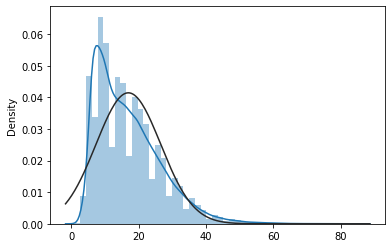

In [13]:
sns.distplot(term_count, fit=norm, kde=True)

In [14]:
import numpy as np

np.mean(term_count)

16.934951537117044

In [15]:
entry = data_mesh_present.MH[2]

In [16]:
G = nx.Graph()

for pmid, entry in zip(data_mesh_present.PMID, data_mesh_present.MH):
  main_node = str(pmid).strip()
  G.add_node(main_node)

  for terms in entry.split(';'):
    terms_list = terms.split('/')

    if (len(terms_list))==1:
      primary = terms_list[0].replace('*', '')
      if G.has_node(primary):
        G.add_edge(main_node, primary)
      else:
        G.add_node(primary)
        G.add_edge(main_node, primary)

    else:
      primary = terms_list[0].replace('*', '')
      if G.has_node(primary):
        G.add_edge(main_node, primary)
      else:
        G.add_node(primary)
        G.add_edge(main_node, primary)

      secondary = terms_list[1:]
      for term in secondary:
        term = term.replace('*', '')
        if G.has_node(term):
          G.add_edge(main_node, term)
        else:
          G.add_node(term)
          G.add_edge(main_node, term)

In [17]:
G.number_of_nodes()

146985

## Shape Of The Network

In [18]:
G.number_of_nodes()

146985

In [19]:
G.number_of_edges()

1882993

In [20]:
density = nx.density(G)
print("Network density:", round(density, 6))

Network density: 0.000174


## Centrality

In [21]:
from operator import itemgetter

In [22]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

In [23]:
len(sorted_degree)

146985

In [24]:
sorted_degree[0]

('Humans', 130253)

In [25]:
np.sqrt(146985)

383.38622823466153

In [26]:
top = 50
print(f"Top {top} nodes by degree:")
for d in sorted_degree[:top]:
    print(d)

Top 50 nodes by degree:
('Humans', 130253)
('COVID-19', 127943)
('SARS-CoV-2', 101980)
('Pandemics', 67930)
('epidemiology', 52684)
('Coronavirus Infections', 40055)
('Pneumonia, Viral', 39919)
('Female', 36195)
('Male', 33946)
('Betacoronavirus', 33175)
('prevention & control', 25135)
('Adult', 23759)
('Middle Aged', 23662)
('virology', 20611)
('diagnosis', 20406)
('methods', 19589)
('Aged', 19421)
('therapy', 16705)
('complications', 14891)
('statistics & numerical data', 14222)
('drug therapy', 13294)
('immunology', 11367)
('therapeutic use', 10976)
('Retrospective Studies', 9935)
('isolation & purification', 9832)
('psychology', 9741)
('genetics', 9313)
('etiology', 9058)
('Young Adult', 8866)
('Adolescent', 8768)
('Child', 8493)
('transmission', 8478)
('metabolism', 8384)
('organization & administration', 8254)
('COVID-19 Vaccines', 7754)
('Aged, 80 and over', 7647)
('United States', 7434)
('blood', 7198)
('Cross-Sectional Studies', 6969)
('Risk Factors', 6826)
('mortality', 6786)

In [27]:
top = 10
top_fifty_nodes = sorted_degree[:top]

In [28]:
mesh_nodes = list()
degrees = list()

for mesh_node, degree in top_fifty_nodes:
  mesh_nodes.append(mesh_node)
  degrees.append(degree)

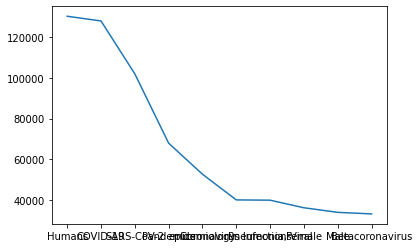

In [29]:
plt.plot(mesh_nodes, degrees)

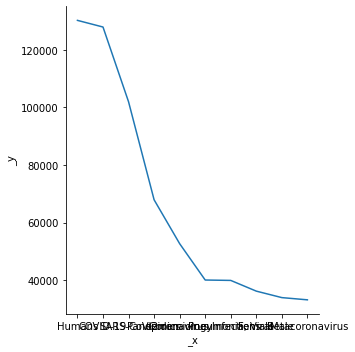

In [30]:
sns.relplot(x=mesh_nodes, y=degrees, kind="line")

In [31]:
for node, value in sorted_degree[:10]:
  print(value/146985)

0.8861652549579889
0.870449365581522
0.6938122937714732
0.46215600231316123
0.35843113242847907
0.27251080042181175
0.2715855359390414
0.24624961730788855
0.23094873626560533
0.22570330305813519


In [32]:
hist_values = [value/146985 for node, value in sorted_degree]

In [33]:
hist_values[:10]

[0.8861652549579889,
 0.870449365581522,
 0.6938122937714732,
 0.46215600231316123,
 0.35843113242847907,
 0.27251080042181175,
 0.2715855359390414,
 0.24624961730788855,
 0.23094873626560533,
 0.22570330305813519]

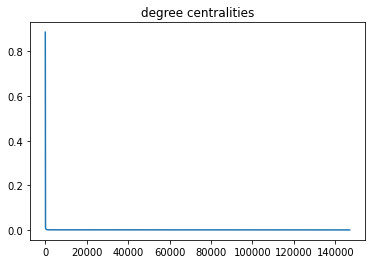

In [34]:
plt.plot(hist_values)
plt.title('degree centralities')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


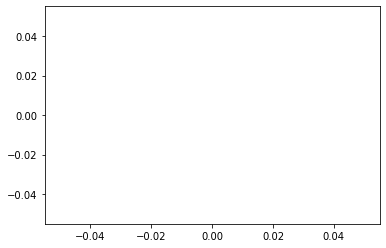

In [35]:
sns.scatterplot(hist_values)